In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd
import os
i=0;
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Image Capcha'):
    for filename in filenames:
        i+=1
        print(os.path.join(dirname, filename))
        if(i>10):
            break

/content/drive/MyDrive/Image Capcha/samples/3d7bd.png
/content/drive/MyDrive/Image Capcha/samples/34fxm.png
/content/drive/MyDrive/Image Capcha/samples/377xx.png
/content/drive/MyDrive/Image Capcha/samples/2wx73.png
/content/drive/MyDrive/Image Capcha/samples/445cc.png
/content/drive/MyDrive/Image Capcha/samples/37d52.png
/content/drive/MyDrive/Image Capcha/samples/36bc2.png
/content/drive/MyDrive/Image Capcha/samples/42dw4.png
/content/drive/MyDrive/Image Capcha/samples/3eny7.png
/content/drive/MyDrive/Image Capcha/samples/368y5.png
/content/drive/MyDrive/Image Capcha/samples/38n57.png
/content/drive/MyDrive/Image Capcha/samples/samples/b4y5x.png


# **Loading images**

In [ ]:
data_dir = Path("/content/drive/MyDrive/Image Capcha/samples")
images = list(data_dir.glob("*.png"))

In [ ]:
print("Number of images:", len(images))

Number of images: 1040


**Defining function for padding**

In [ ]:
kernel =np.ones((3,1),np.uint8)
borderType = cv2.BORDER_CONSTANT
def pad(src):
    top = int(0.05 * src.shape[0])
    bottom = top
    left = int(0.15 * src.shape[1])
    right = left
    des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
    return cv2.bitwise_not(des)

**CREATING LABELLED DATA**

In [ ]:
x=[]
y=[]
for image in images:
    im=cv2.imread(str(image),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    s=str(image)
    for i in range(5):
        x.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
        y.append(s[-9+i])

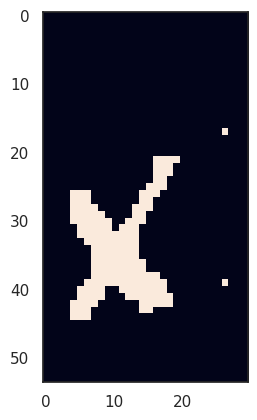

In [ ]:
plt.imshow(x[56])

In [ ]:
y[56]

'x'

In [ ]:
x=np.array(x)
y=np.array(y)

**TO see which characters are present and their corresponding frequencies , to ensure that our data is not biased**

In [ ]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[['2' '265']
 ['3' '267']
 ['4' '284']
 ['5' '281']
 ['6' '259']
 ['7' '258']
 ['8' '264']
 ['b' '240']
 ['c' '262']
 ['d' '259']
 ['e' '235']
 ['f' '271']
 ['g' '271']
 ['m' '275']
 ['n' '525']
 ['p' '253']
 ['w' '235']
 ['x' '264']
 ['y' '232']]


In [ ]:
data=np.reshape(x,(-1,54,30,1))

# Converting labels in one-hot encoder form

In [ ]:
train = []
l=['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
for j in y:
    i=l.index(j)
    a=[]
    for r in range(19):
        if(r==i):
            a.append(1)
        else:
            a.append(0)
    a=np.array(a)
    train.append(a)
train=np.array(train)

# **Importing libraries to definne our model**

In [ ]:
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Reshape, LSTM
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# **Defining architecture of our Model**

In [ ]:
import pdb

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), padding='Same',
                 activation='relu', input_shape=(50, 30, 1)))  # Change input shape

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#pdb.set_trace()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#50 30
model.add(Reshape(((50 // 8), (30 // 8)*64)))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))


model.add((LSTM(128,return_sequences=True,dropout=0.2)))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

**Optimizer Functions**

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 50, 30, 16)        416       
                                                                 
 conv2d_38 (Conv2D)          (None, 50, 30, 16)        6416      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 25, 15, 16)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 25, 15, 16)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 25, 15, 32)        12832     
                                                                 
 conv2d_40 (Conv2D)          (None, 25, 15, 32)        25632     
                                                      

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

**Splitting Data**

In [ ]:
# Load and preprocess the data
X_train, X_val, Y_train, Y_val = train_test_split(data, train, test_size=0.2, random_state=2)

# Resize images to (50, 30, 1)
X_train_resized = np.array([cv2.resize(img, (30, 50)) for img in X_train])
X_val_resized = np.array([cv2.resize(img, (30, 50)) for img in X_val])

X_train_resized = X_train_resized / 255.0  # Normalize
X_val_resized = X_val_resized / 255.0

# Data Augmentation

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False
)


# Fitting data into the Model

In [ ]:
# Fitting the Model
history = model.fit(
    datagen.flow(X_train_resized, Y_train, batch_size=batch_size),
    epochs=15,
    validation_data=(X_val_resized, Y_val),
    verbose=1,
    steps_per_epoch=X_train_resized.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)


Epoch 1/15
48/48 [==============================] - 60s 1s/step - loss: 2.8894 - accuracy: 0.1095 - val_loss: 2.6418 - val_accuracy: 0.2394 - lr: 0.0010
Epoch 2/15
48/48 [==============================] - 51s 1s/step - loss: 2.4871 - accuracy: 0.2140 - val_loss: 1.8035 - val_accuracy: 0.4240 - lr: 0.0010
Epoch 3/15
48/48 [==============================] - 51s 1s/step - loss: 2.0241 - accuracy: 0.3488 - val_loss: 1.3766 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 4/15
48/48 [==============================] - 50s 1s/step - loss: 1.6465 - accuracy: 0.4708 - val_loss: 1.0314 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 5/15
48/48 [==============================] - 49s 1s/step - loss: 1.4035 - accuracy: 0.5501 - val_loss: 0.7675 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 6/15
48/48 [==============================] - 57s 1s/step - loss: 1.1769 - accuracy: 0.6271 - val_loss: 0.6986 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 7/15
48/48 [==============================] - 48s 994ms/step - loss: 1.0079 

# Analysing losses

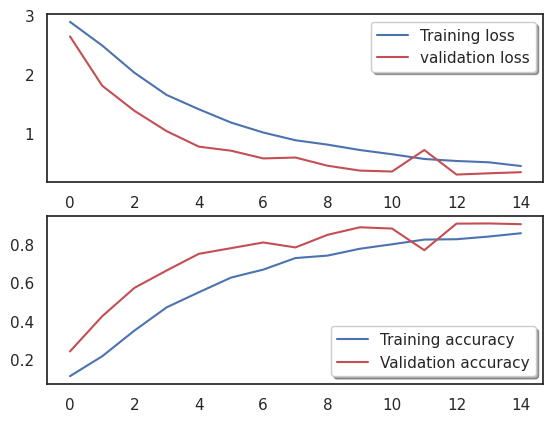

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Analysing out top-6 wrongly identified characters

In [ ]:
X_val_resized = np.array([cv2.resize(img, (30, 50)) for img in X_val])
Y_pred = model.predict(X_val_resized)

33/33 [==============================] - 3s 70ms/step


33/33 [==============================] - 3s 75ms/step
Predicted label :11
True label :14
Predicted label :11
True label :16
Predicted label :9
True label :2
Predicted label :11
True label :16
Predicted label :0
True label :10
Predicted label :11
True label :14


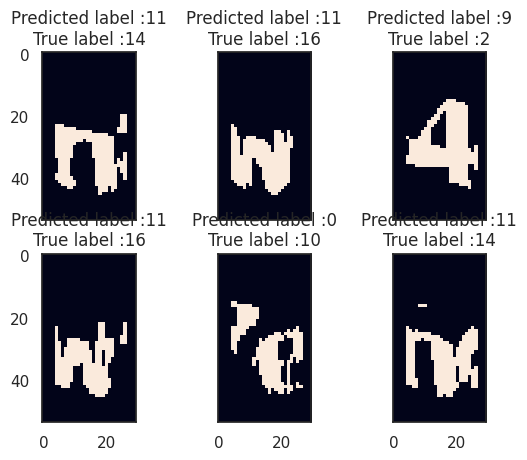

In [ ]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((54,30)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            print("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Analysis on Cpatcha images


In [ ]:
def captcha(img,p):
    im=cv2.imread(str(img),0)
    threshold=cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
    erosion =cv2.dilate(threshold,kernel,iterations=2)
    images=[]
    for i in range(5):
        images.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
    images=np.reshape(images,(-1,54,30,1))
    pred=model.predict(images)
    pred=np.argmax(pred,axis = 1)
    predicted=str(l[pred[0]]+l[pred[1]]+l[pred[2]]+l[pred[3]]+l[pred[4]])
    if(p):
        print(predicted)
    if(predicted==img[-9:-4]):
        return 1
    return 0


In [ ]:
images = list(data_dir.glob("*.png"))
t=0
for i in images:
    t+=captcha(str(i),False)

1/1 [==============================] - 0s 33ms/step


# Acuuracy

In [ ]:
print("total images",len(images),"correctly identified",t)
print("Accuracy is",t/len(images))

total images 1040 correctly identified 59
Accuracy is 0.05673076923076923


# A Single Captcha Code

In [ ]:
img='/content/drive/MyDrive/Image Capcha/samples/w4x2m.png'
captcha(img,True)

1/1 [==============================] - 0s 73ms/step
fpb2b


0